# Demo 2: Random Forest
Random Forest is a popular machine learning algorithm that belongs to the supervised laerning technique. It can be used for both Classification and Regression problems in ML. It is based on the concept of ensemble learning, which is a process of combining multiple classifiers to solve a complex problem and to improve the performance of the model.

Instead of relying on one decision tree, the random forest takes the prediction from each tree and based on the majority votes of predictions, and it predicts the final output.

![Screenshot 2023-11-20 at 1.52.12 PM.png](<attachment:Screenshot 2023-11-20 at 1.52.12 PM.png>)

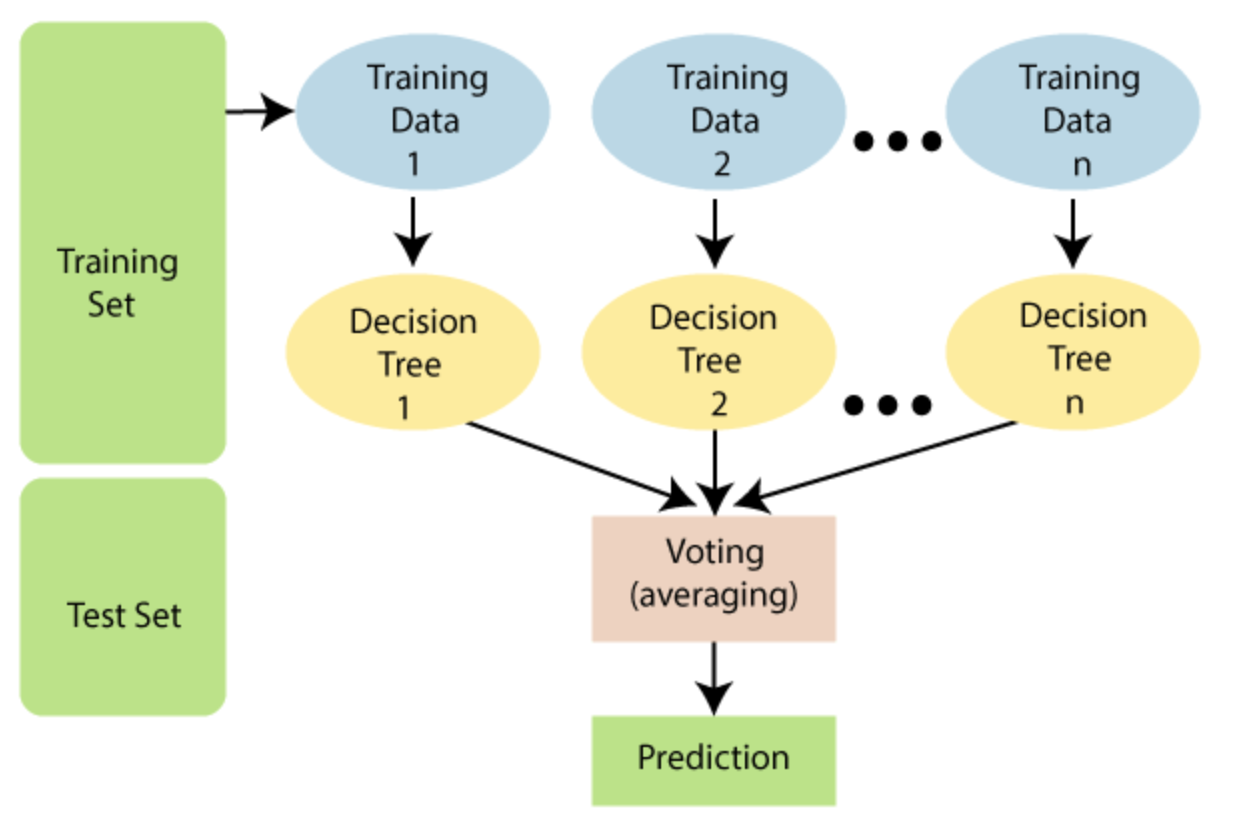

The Random Forest model in this demo will also try to solve the classification problem as we have done before in the section S1_Classification:

-   Problem: Defect detection classification (with the NEU surface defect dataset)
-   Dataset: NEU surface defect dataset <http://faculty.neu.edu.cn/songkechen/zh_CN/zhym/263269/list/index.htm>(NEU SDD)
-   Library package:
    -   Scikit-Learn (Machine Learning models: KNN,SVM,Decision Tree,...)
    -   PIL (Simple image processing package: read, show, resize,...)
    -   Matplotlib (Plot package: visualize result,....)

Tasks Outlines:
## 0. Task 0: Preparing dataset
-   Downloads dataset, unpacking dataset,...
-   Transform it to input (features) and ouput (labels) where the model in Scikit-Learn can read, and training on,...
-   Normalize or standardlize dataset (we may do it after some evaluations on the raw data)
-   Devide dataset to trainset and testset (maybe one more validation_set) or using the cross validation to evaluate the performance of model
## 1. Task 1: Random Forest model:
-   RandomForestClassifier
-   Training model on our trainset
## 2. Task 2: Evaluating the performance on the testset:
-   Compute the metrics (quantitative measurements) on the classification task:
    -   Accuracy
    -   Precesion, Recall, F1 Score
    -   Confusion Matrix
## 3. Task 3: Evaluating the performance of model by Cross Validation method.
## 4. Task 4: Hyperparameter Turing.
*****************************************************************************

# Import all packages

In [31]:
import os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

# import models
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

# import method to evaluate performance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import classification_report,ConfusionMatrixDisplay

# import for hyperparameter turning
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV


## 0. Task 0: Preparing Dataset

Go to the notebook file: Demo_Read_NEU_dataset.ipynb to get detail of demo code for this step

### 0.1. Define a function get all paths to each image in the dataset and the class label of each image

In [2]:
def get_all_img_label_path(input_dir:str,
                            img_suffix = '.bmp')->(list,list):
    """
    parameters:
    -   input_dir: the directory to the data folder
    -   img_suffix: siffix type of image in the data folder to read
    output: a tuple of two lists:
    -   List of all path to each image in the data folder
    -   List of relative class for each image in the data folder
    """
    label_to_number = {"Cr":0,"In":1,"Pa":2,"PS":3,"RS":4,"Sc":5}
    list_img_paths = []
    list_labels = []
    for root,dirs,files in os.walk(input_dir):
        for file in files:
            file_name,file_suffix = os.path.splitext(file)
            if file_suffix == img_suffix:
                list_img_paths.append(os.path.join(root,file))
                list_labels.append(label_to_number[file_name[:2]])
    return (list_img_paths,list_labels)


### 0.2. Define a function to get all image array and its class label (which are in type np.array)
In this function we also resize the all image to the same new size = (width, height)

In [3]:
# Resize the image to small dimensional of width and height
def get_data(list_img_paths:list,
             list_labels:list,
             is_resize:bool= True,
             width:int = 8,
             height:int = 8) -> (np.array,np.array):
    """
    Parameters:
    -   list_img_paths: List of all paths to image in the data folder
    -   list_labels: The list of labels relative to each image in the list_img_paths
    -   is_resize: Default is True means resize all image in the dataset
        to the new size (width,height)
    -   width: The width size which we want to resize to
    -   height: The height size which we want to resize to

    Output: A tuple of two arrays
    -   data_array with shape (N,h,w), where
        -   N is the number of image
        -   h is the height
        -   w is the width
    -   label_array with shape (N,)
    """
    data = []
    for i in range(len(list_img_paths)):
        path_img = list_img_paths[i]
        img = Image.open(path_img)
        if is_resize:
            img = img.resize(size = (width,height),
                            resample=Image.BICUBIC)
        data.append(np.array(img))
    return (np.array(data),np.array(list_labels))

### 0.3. Getting data by using two previouse function

In [4]:
# Get the list of all path to images, and the list of relative labels
dir_NEUCLS = "/Users/user/Victor2023/Dataset/NEU-CLS"
list_img_paths,list_labels = get_all_img_label_path(input_dir=dir_NEUCLS,
                                                    img_suffix='.bmp')

width = 28
height = 28
X,y = get_data(list_img_paths=list_img_paths,
               list_labels=list_labels,
               is_resize=True,
               width=width,
               height= height)

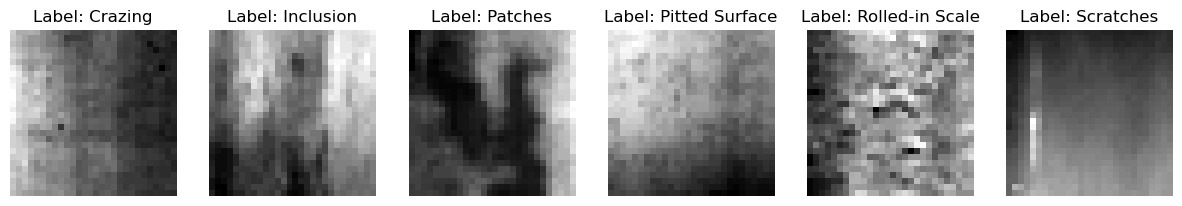

In [5]:
# Plotting some images to take an overview of our dataset
index_to_label = ["Crazing","Inclusion","Patches","Pitted Surface","Rolled-in Scale","Scratches"]
# Visualize one sample of each class
_, indices = np.unique(y,return_index=True) # get one index of each class
# Plot
_, axes = plt.subplots(nrows = 1,
                       ncols = len(indices),
                       figsize = (15,6))
for i in range(len(indices)):
    index = indices[i]
    axes[i].set_axis_off()
    axes[i].imshow(X[index], cmap = plt.cm.gray, interpolation= "nearest")
    axes[i].set_title(f"Label: {index_to_label[y[index]]}")

### Note!
The shape of data for KNN model should be (N_samples,N_features). In which:
-   N_samples: The total number of samples we have (number of images)
-   N_features: the number of features in each sample

Back to our data:
-   Data is image in grayscale we resize to same size (width,height), here is 28 x 28 pixels. Each pixels is one feature of sample, so totally we have 28*28 number of features for each sample.
-   We have to reshape our data from (N_samples,height,width) to (N_samples,height * width)


In [6]:
n_samples = X.shape[0]
X = X.reshape((n_samples,-1))
# Scaling feature from range [0,255] to range [0,1]
# Each pixel is a feature of input image, which has normally value in range [0,255] 
X = X/255

### 0.4. Deviding our dataset to trainset and testset

In [7]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,shuffle=False)

## 1. Task 1: Random Forest model
### 1.1. Getting the random forest model from scikit-learn
-   How many decision tree in this random forest (n_estimators)
-   Which criterion we are using in this model (criterion)

In [17]:
# Create a RandomForestClassifier with 10 estimators, criterion = log_loss 
n_estimators = 10
criterion = "log_loss"
rf_model = RFC(n_estimators = n_estimators,
               criterion = criterion)

### 1.2. Training for our model (Fitting data to our model)

In [18]:
# Training model:
rf_model.fit(X_train,y_train)


RandomForestClassifier(criterion='log_loss', n_estimators=10)

## 2. Task 2: Evaluating the performance of trained model on the testset

In [19]:
# Predict on test set:
pred_test = rf_model.predict(X_test)

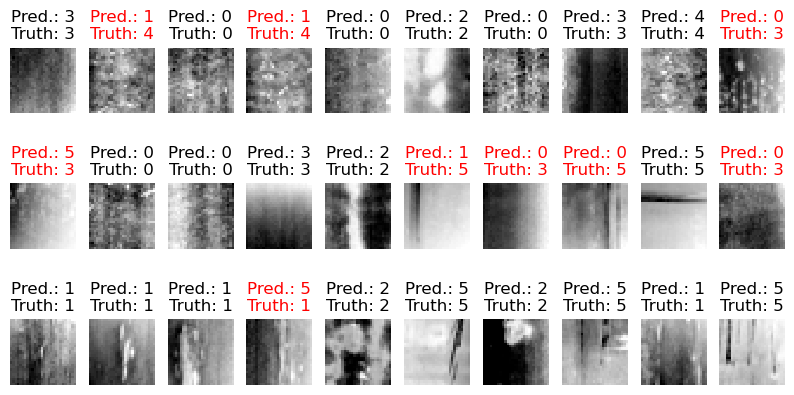

In [20]:
# Visualize the first 30 test samples and show their predicted digit value in the title.
_,axes = plt.subplots(nrows = 3,ncols = 10, figsize= (10,5))
for r in range(3):
    for c in range(10):
        index = r*10 + c
        axes[r,c].set_axis_off()
        image = X_test[index].reshape((width,height))
        pred_label = pred_test[index]
        true_label = y_test[index]
        axes[r,c].imshow(image, cmap = plt.cm.gray_r, interpolation = "nearest")
        if pred_label == true_label:
            axes[r,c].set_title(f"Pred.: {pred_label}\nTruth: {true_label}")
        else:
            axes[r,c].set_title(f"Pred.: {pred_label}\nTruth: {true_label}",color = 'red')

In [21]:
# Classification report:
print(f"Classification report for classifier {rf_model}:\n"
      f"{classification_report(y_test,pred_test,digits=4)}\n")

Classification report for classifier RandomForestClassifier(criterion='log_loss', n_estimators=10):
              precision    recall  f1-score   support

           0     0.6184    0.7231    0.6667        65
           1     0.6714    0.7015    0.6861        67
           2     0.8837    0.8085    0.8444        47
           3     0.8197    0.7246    0.7692        69
           4     0.5614    0.7111    0.6275        45
           5     0.7170    0.5672    0.6333        67

    accuracy                         0.7000       360
   macro avg     0.7119    0.7060    0.7045       360
weighted avg     0.7127    0.7000    0.7021       360




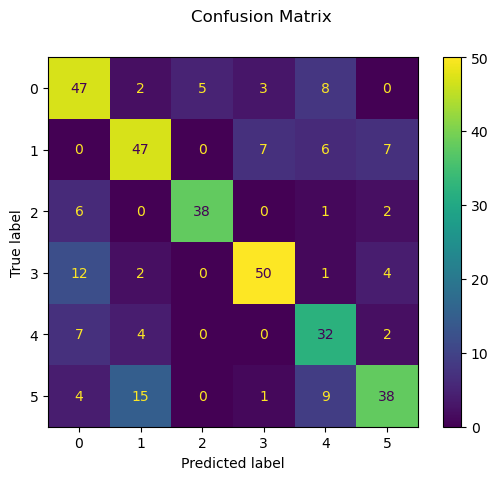

In [22]:
# Confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(y_test,pred_test)
disp.figure_.suptitle("Confusion Matrix")
# print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.show()

## 3. Task 3: Evaluating the performance of model by Cross Validation method.
We will compare cross validation score of RF model with the other five models in this task

In [27]:
# Define a function to get a list of models to evaluate
def get_models():
    models = dict()
    models['lr'] = LogisticRegression(solver='lbfgs',max_iter=1000)
    models['knn'] = KNeighborsClassifier(n_neighbors=3)
    models['dtree'] = DecisionTreeClassifier(criterion='log_loss')
    models['svm'] = SVC(C=10,kernel='rbf')
    models['bayes'] = MultinomialNB()
    models['rf'] = RFC(n_estimators = 10,
               criterion = "log_loss")
    return models

In [28]:
# Define a function with input is model data input (X), label (y), 
# then compute the cross validation score for model with kfold = 10
# Repeat this 3 times, n_repeats = 3
def evaluate_model(model,X,y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3,random_state=1)
    scores = cross_val_score(model,X,y,
                             scoring='accuracy',
                             cv=cv,
                             n_jobs=1,
                             error_score='raise')
    return scores

Model name lr, mean of cv score: 0.4996296296296296, std of cv score: 0.0297774092477656
Model name knn, mean of cv score: 0.569814814814815, std of cv score: 0.03170995525072125
Model name dtree, mean of cv score: 0.5914814814814816, std of cv score: 0.03209852801431667
Model name svm, mean of cv score: 0.7909259259259259, std of cv score: 0.03485665334737221
Model name bayes, mean of cv score: 0.3125925925925926, std of cv score: 0.03712766689187485
Model name rf, mean of cv score: 0.7268518518518519, std of cv score: 0.034696904349923834


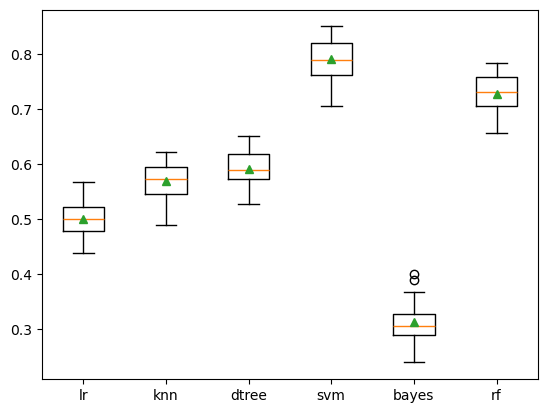

In [29]:
# Get the models to evaluate
models = get_models()
# Evaluate the models, store results, visualize results
results, names = list(),list()
for name, model in models.items():
    scores = evaluate_model(model,X,y)
    results.append(scores)
    names.append(name)
    print(f"Model name {name}, mean of cv score: {np.mean(scores)}, std of cv score: {np.std(scores)}")
plt.boxplot(results,labels=names,showmeans=True)
plt.show()

## 4. Task 4: Hyperparameter Tuning
In this task we will use Scikit-Learn's RandomizedSearchCV, which will randomly search parameters within a range per hyperparameter. We define the hyperparameters to use and their ranges in the param_dist dictionary. In our case, we are using:

-   n_estimators: the number of decision trees in the forest. Increasing this hyperparameter generally imporves the performance of the model but also increases the computational cose of training and predicting.
-   max_depth: the maximum depth of each decision tree in the forest. Setting a higher value for max_depth can lead to overfitting while setting it too low can lead to underfitting.

### 4.1. Search the best hyperparameter

In [33]:
para_dist = {'n_estimators': randint(50,500),
             'max_depth': randint(1,20)}
# Create a random forest classifier
rf_to_eval = RFC()

# Use the random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf_to_eval,
                                 param_distributions = para_dist,
                                 n_iter = 5,
                                 cv = 5)
# Fit the random search object to the trainset
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fcd47350370>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fcd47350970>})

In [34]:
# Get the result, the best model
best_rf = rand_search.best_estimator_
# Print the best hyperparameters
print('Best hyperparameters:', rand_search.best_params_)

Best hyperparameters: {'max_depth': 18, 'n_estimators': 379}


### 4.2. Evaluating performance on the testset

In [35]:
# Evaluating performance of best model on the test set
pred_best_rf = best_rf.predict(X_test)

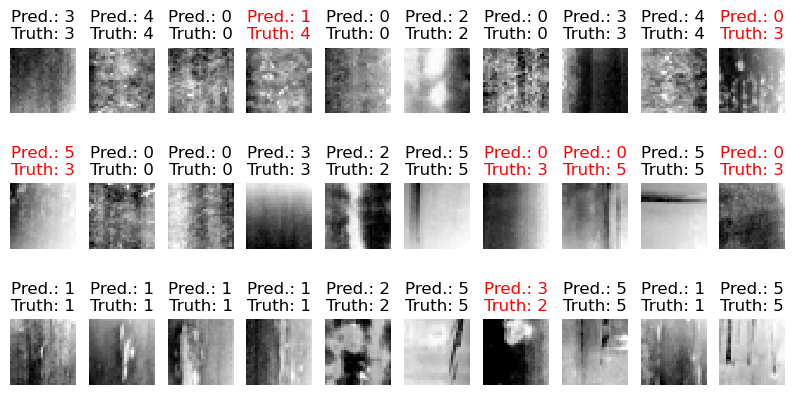

In [36]:
# Visualize the first 30 test samples and show their predicted digit value in the title.
_,axes = plt.subplots(nrows = 3,ncols = 10, figsize= (10,5))
for r in range(3):
    for c in range(10):
        index = r*10 + c
        axes[r,c].set_axis_off()
        image = X_test[index].reshape((width,height))
        pred_label = pred_best_rf[index]
        true_label = y_test[index]
        axes[r,c].imshow(image, cmap = plt.cm.gray_r, interpolation = "nearest")
        if pred_label == true_label:
            axes[r,c].set_title(f"Pred.: {pred_label}\nTruth: {true_label}")
        else:
            axes[r,c].set_title(f"Pred.: {pred_label}\nTruth: {true_label}",color = 'red')

In [38]:
# Classification report:
print(f"Classification report for classifier {best_rf}:\n"
      f"{classification_report(y_test,pred_best_rf,digits=4)}\n")

Classification report for classifier RandomForestClassifier(max_depth=18, n_estimators=379):
              precision    recall  f1-score   support

           0     0.6970    0.7077    0.7023        65
           1     0.8000    0.6567    0.7213        67
           2     0.8654    0.9574    0.9091        47
           3     0.8462    0.7971    0.8209        69
           4     0.5484    0.7556    0.6355        45
           5     0.8000    0.7164    0.7559        67

    accuracy                         0.7556       360
   macro avg     0.7595    0.7652    0.7575       360
weighted avg     0.7673    0.7556    0.7572       360




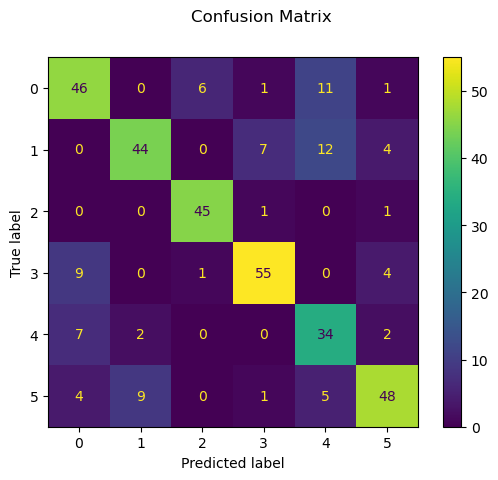

In [39]:
# Confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(y_test,pred_best_rf)
disp.figure_.suptitle("Confusion Matrix")
# print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.show()